In [148]:
from DecisionTree import DecisionTree
from Model import *
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import re
from sklearn.model_selection import cross_val_score, train_test_split, cross_validate
from sklearn.metrics import roc_auc_score, roc_curve, RocCurveDisplay, precision_score, recall_score, auc as AUC

In [36]:
def visualize_decision_tree_networkx(rules):
    G = nx.DiGraph()    
    G.add_node("Root", label="Root", layer=0)
    
    for i, rule in enumerate(rules):
        conditions, outcome = rule.split(' THEN ')
        node_name = f'Node_{i+1}'

        # Parse and round conditions
        rounded_conditions = []
        for cond in conditions.split(' AND '):
            # Find and round all float numbers in the condition string
            rounded_condition = re.sub(r'(\d+\.\d+)', lambda x: f'{float(x.group(0)):0.2f}', cond)
            rounded_conditions.append(rounded_condition)
        
        rounded_conditions = ' AND '.join(rounded_conditions)
        rounded_outcome = tuple(round(float(num), 2) for num in outcome.strip('()').split(', '))
        
        G.add_node(node_name, label=f'{rounded_conditions}\n{rounded_outcome}', layer=1)
        G.add_edge("Root", node_name, label=f'Rule {i+1}')
    
    pos = nx.spring_layout(G)
    pos = {node: (y, -x) for node, (x, y) in pos.items()}
    nx.draw(G, pos, with_labels=True, labels={node: G.nodes[node]['label'] for node in G.nodes}, node_size=5000, node_color='lightblue', font_size=8, font_weight='bold', arrowstyle='-|>', arrowsize=20)
    edge_labels = nx.get_edge_attributes(G, 'label')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red')
    
    plt.xlim(min(pos[key][0] for key in pos)-1, max(pos[key][0] for key in pos)+1)
    plt.ylim(min(pos[key][1] for key in pos)-1, max(pos[key][1] for key in pos)+1)
    plt.show()


In [157]:

def get_stats(labels, preds, do_plt = True):
    accuracy = np.sum(preds == labels) / len(labels)
    precision = np.mean([np.sum(labels[preds == x] == x) / np.sum(preds == x) for x in np.unique(preds)])
    recall = np.mean([np.sum(preds[labels == x] == x) / np.sum(labels == x) for x in np.unique(labels)])
    conf = np.array([[np.sum(labels[preds == y] == x) for x in np.unique(labels)] for y in np.unique(labels)])
    if do_plt:
        print(f'Accuracy: {accuracy:.4f}')
        print(f'Precision: {precision:.4f}')
        print(f'Recall: {recall:.4f}')
        fig, ax = plt.subplots(figsize=(4, 4))
        cax = ax.matshow(conf, cmap=plt.cm.Blues)
        plt.title('Confusion Matrix')
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.xticks(ticks=np.arange(len(np.unique(labels))), labels=np.unique(labels))
        plt.yticks(ticks=np.arange(len(np.unique(labels))), labels=np.unique(labels))
    
        # Annotate each cell with the numeric value
        for i in range(len(np.unique(labels))):
            for j in range(len(np.unique(labels))):
                ax.text(j, i, str(conf[i, j]), va='center', ha='center', color='black')
        
        plt.show()
    
    return accuracy, precision, recall, conf


# Dataset COVID

### CART

In [38]:
df = pd.read_csv('dataset/Covid19.csv')
data, targets = df.values[:, :-1], df.values[:, -1]
train_data, val_data, train_labels, val_labels = train_test_split(data, targets, test_size = 0.2, random_state = 42)

Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000


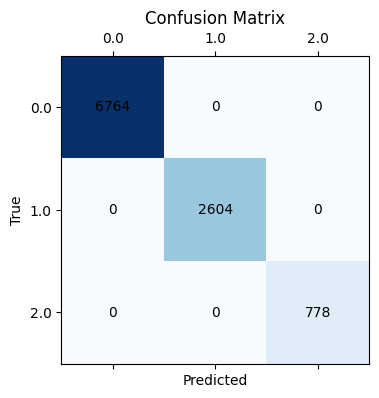

In [39]:
dt = DecisionTree(max_depth = 3, method = 'cart')
dt.fit(train_data, train_labels)
preds = dt.predict(val_data)
stat = get_stats(val_labels, preds)

In [40]:
rules = dt.get_rules()


In [41]:
rules

['X6 IS 0.0 AND X3 IS 0.0 AND X2 IS 0.0 THEN (0.0, 0.0)',
 'X6 IS 0.0 AND X3 IS 0.0 AND X2 IS NOT 0.0 THEN (1.0, 1.0)',
 'X6 IS 0.0 AND X3 IS NOT 0.0 THEN (2.0, 0.0)',
 'X6 IS NOT 0.0 THEN (1.0, 1.0)']

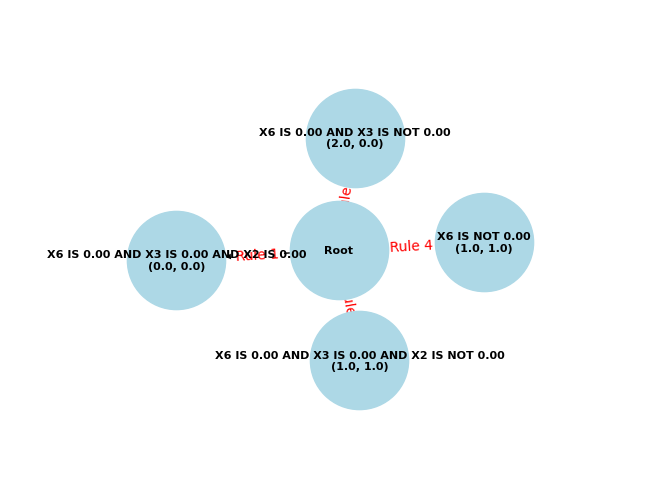

In [42]:
visualize_decision_tree_networkx(rules)


#### exploring max depth effect

Best max_depth: 3 with cross-validated accuracy: 0.8659


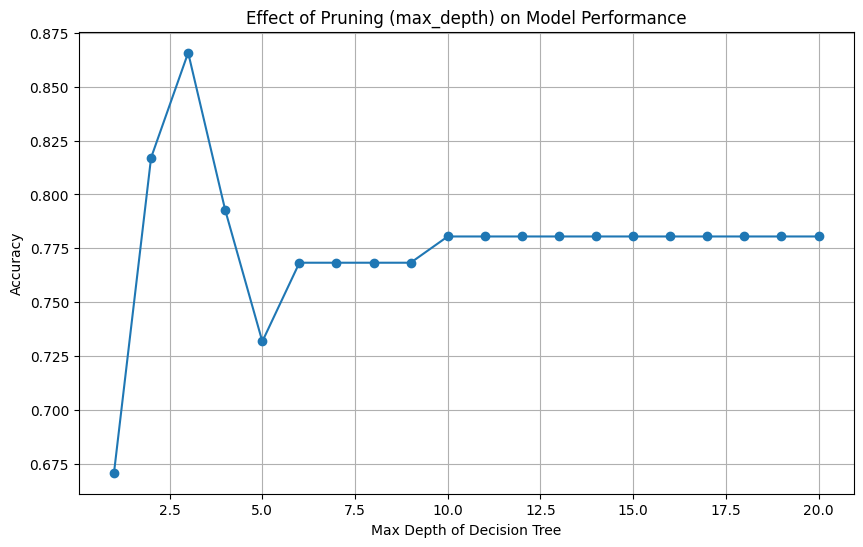

In [161]:
max_depths = range(1, 21)
cv_scores = []

for i in max_depths:
    dt = DecisionTree(max_depth = i, method = 'cart')
    dt.fit(train_data, train_labels)
    preds = dt.predict(val_data)
    stat = get_stats(val_labels, preds, False)
    cv_scores.append(stat[0])

best_max_depth = max_depths[np.argmax(cv_scores)]
print(f'Best max_depth: {best_max_depth} with cross-validated accuracy: {max(cv_scores):.4f}')

plt.figure(figsize=(10, 6))
plt.plot(max_depths, cv_scores, marker='o')
plt.xlabel('Max Depth of Decision Tree')
plt.ylabel('Accuracy')
plt.title('Effect of Pruning (max_depth) on Model Performance')
plt.grid(True)
plt.show()

### C4.5

Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000


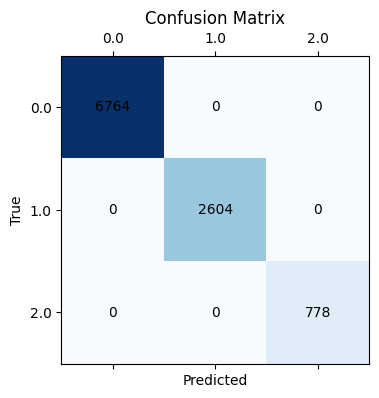

In [43]:
dt = DecisionTree(max_depth = 3, method = 'c4.5')
dt.fit(train_data, train_labels)
preds = dt.predict(val_data)
stat = get_stats(val_labels, preds)

In [44]:
rules = dt.get_rules()

In [45]:
rules

['X3 IS 0.0 AND X6 IS 0.0 AND X2 IS 0.0 THEN (0.0, 0.0)',
 'X3 IS 0.0 AND X6 IS 0.0 AND X2 IS 1.0 THEN (1.0, 1.0)',
 'X3 IS 0.0 AND X6 IS 1.0 THEN (1.0, 1.0)',
 'X3 IS 0.0 AND X6 IS 2.0 THEN (1.0, 1.0)',
 'X3 IS 0.0 AND X6 IS 3.0 THEN (1.0, 1.0)',
 'X3 IS 1.0 THEN (2.0, 0.0)']

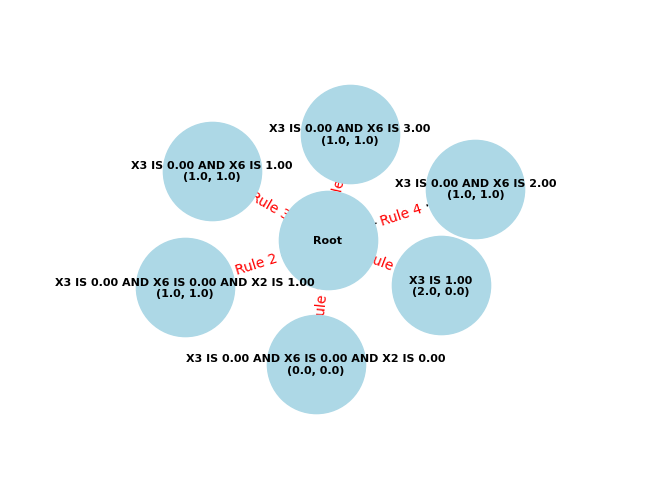

In [46]:
visualize_decision_tree_networkx(rules)

## sickit learn classifier

Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000


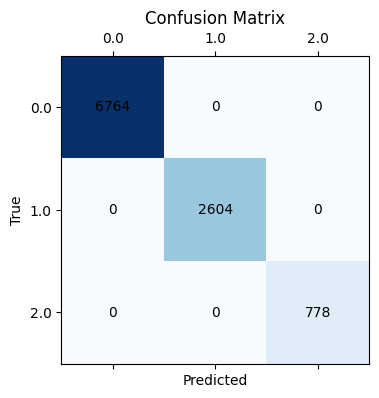

In [47]:
dtc = DecisionTreeClassifier(max_depth = 3)
dtc.fit(train_data, train_labels)
preds = dtc.predict(val_data)
stat = get_stats(val_labels, preds)

## OVA and OVO

Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000


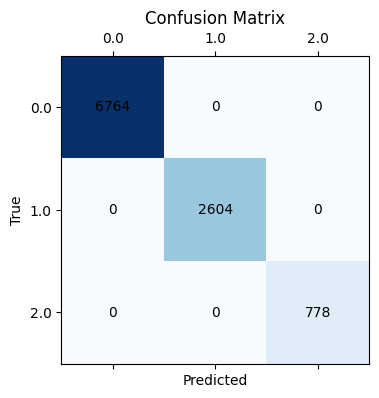

In [48]:
ova_tree = OnevsAll(DecisionTree, max_depth = 3, method = 'cart')
ova_tree.fit(train_data, train_labels)
preds = ova_tree.predict(val_data)
stat = get_stats(val_labels, preds)

Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000


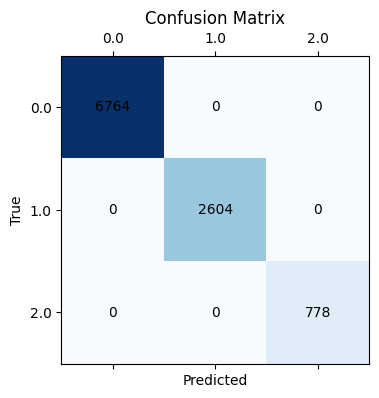

In [49]:
ovo_tree = OnevsOne(DecisionTree, max_depth = 3)
ovo_tree.fit(train_data, train_labels)
preds = ovo_tree.predict(val_data)
stat = get_stats(val_labels, preds)

# Dataset Heart

In [85]:
from EnsembleLearning import SMOTE

In [118]:
file_path = 'dataset/heart.csv'
data = pd.read_csv(file_path)
features = data.drop(columns=['DEATH_EVENT', 'time'])
features_name = data.columns
targets = data['DEATH_EVENT'].values
scaler = MinMaxScaler()
normalized_features = scaler.fit_transform(features)
data = pd.DataFrame(normalized_features, columns=features.columns).values
unique_labels, counts = np.unique(targets, return_counts=True)
class_weights = {label: sum(counts) / count for label, count in zip(unique_labels, counts)}
print(class_weights)
sm = SMOTE()
sm.fit(data, targets)
new_art_data, new_art_labels = sm.resample()

{0: 1.4729064039408868, 1: 3.1145833333333335}


In [119]:
train_data, val_data, train_labels, val_labels = train_test_split(new_art_data, new_art_labels, test_size = 0.2, random_state = 42)

## CART

Accuracy: 0.8659
Precision: 0.8678
Recall: 0.8659


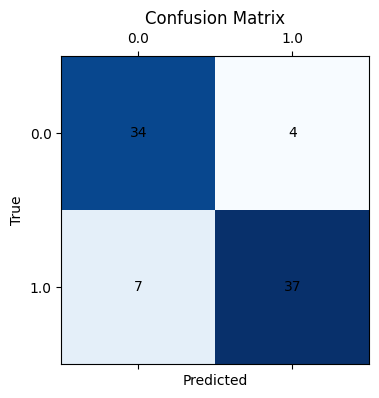

In [127]:
dt = DecisionTree(max_depth = 3, method = 'cart')
dt.fit(train_data, train_labels)
preds = dt.predict(val_data)
stat = get_stats(val_labels, preds)

In [128]:
rules = dt.get_rules()

In [129]:
rules

['X4 < 0.24025814797496042 AND X2 < 0.005039550905843327 THEN (0.0, 0.19999999999999996)',
 'X4 < 0.24025814797496042 AND X2 >= 0.005039550905843327 AND X7 < 0.0792361542138873 THEN (1.0, 0.75)',
 'X4 < 0.24025814797496042 AND X2 >= 0.005039550905843327 AND X7 >= 0.0792361542138873 THEN (1.0, 0.9482758620689655)',
 'X4 >= 0.24025814797496042 AND X7 < 0.1033576109709317 AND X0 < 0.7015986300071916 THEN (0.0, 0.18000000000000005)',
 'X4 >= 0.24025814797496042 AND X7 < 0.1033576109709317 AND X0 >= 0.7015986300071916 THEN (1.0, 0.75)',
 'X4 >= 0.24025814797496042 AND X7 >= 0.1033576109709317 AND X0 < 0.5636363636363636 THEN (1.0, 0.5454545454545454)',
 'X4 >= 0.24025814797496042 AND X7 >= 0.1033576109709317 AND X0 >= 0.5636363636363636 THEN (1.0, 0.8636363636363636)']

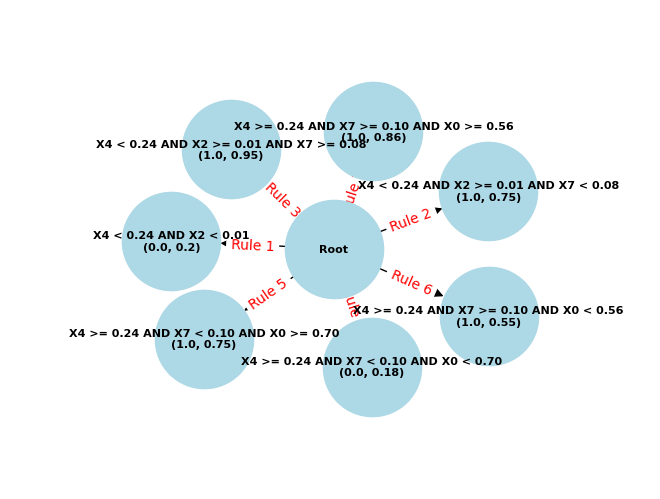

In [130]:
visualize_decision_tree_networkx(rules)


## C4.5

Accuracy: 0.8659
Precision: 0.8678
Recall: 0.8659


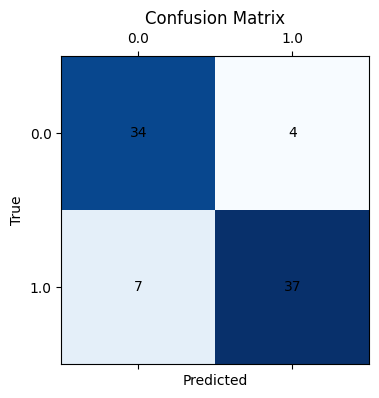

In [131]:
dt = DecisionTree(max_depth = 3, method = 'c4.5')
dt.fit(train_data, train_labels)
preds = dt.predict(val_data)
stat = get_stats(val_labels, preds)

In [132]:
rules = dt.get_rules()

In [133]:
rules

['X4 < 0.24025814797496042 AND X2 < 0.005039550905843327 THEN (0.0, 0.19999999999999996)',
 'X4 < 0.24025814797496042 AND X2 >= 0.005039550905843327 AND X7 < 0.09190123811840797 THEN (1.0, 0.7708333333333334)',
 'X4 < 0.24025814797496042 AND X2 >= 0.005039550905843327 AND X7 >= 0.09190123811840797 THEN (1.0, 0.96)',
 'X4 >= 0.24025814797496042 AND X7 < 0.1033576109709317 AND X0 < 0.7015986300071916 THEN (0.0, 0.18000000000000005)',
 'X4 >= 0.24025814797496042 AND X7 < 0.1033576109709317 AND X0 >= 0.7015986300071916 THEN (1.0, 0.75)',
 'X4 >= 0.24025814797496042 AND X7 >= 0.1033576109709317 AND X6 < 0.0380652200266699 THEN (0.0, 0.0)',
 'X4 >= 0.24025814797496042 AND X7 >= 0.1033576109709317 AND X6 >= 0.0380652200266699 THEN (1.0, 0.6851851851851852)']

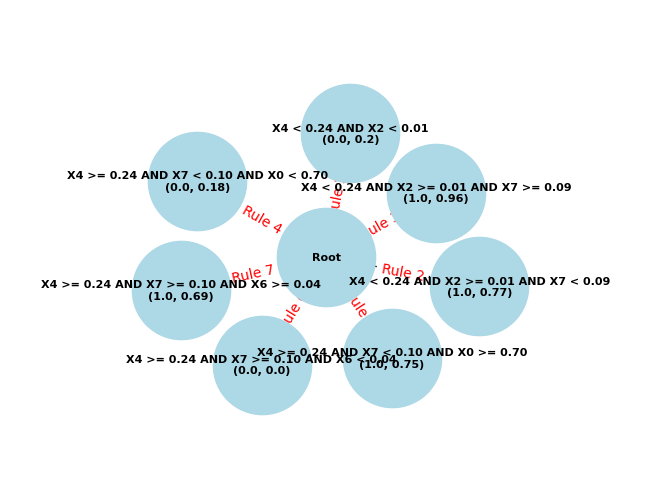

In [134]:
visualize_decision_tree_networkx(rules)

## scikit classifier

Accuracy: 0.7333
Precision: 0.7343
Recall: 0.7086


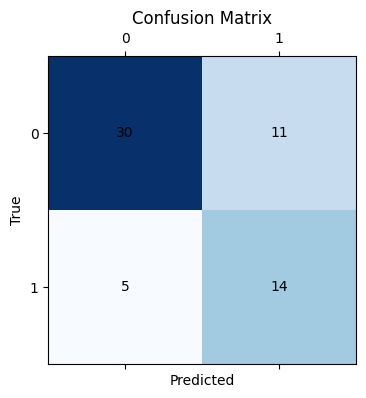

In [73]:
train_data, val_data, train_labels, val_labels = train_test_split(data, targets, test_size = 0.2, random_state = 42)
dtc = DecisionTreeClassifier(max_depth = 3)
dtc.fit(train_data, train_labels)
preds = dtc.predict(val_data)
stat = get_stats(val_labels, preds)

In [146]:
from sklearn import tree
text_representation = tree.export_text(dtc)
print(text_representation)

|--- feature_7 <= 0.15
|   |--- feature_4 <= 0.28
|   |   |--- feature_7 <= 0.05
|   |   |   |--- class: 0
|   |   |--- feature_7 >  0.05
|   |   |   |--- class: 1
|   |--- feature_4 >  0.28
|   |   |--- feature_0 <= 0.72
|   |   |   |--- class: 0
|   |   |--- feature_0 >  0.72
|   |   |   |--- class: 1
|--- feature_7 >  0.15
|   |--- feature_7 <= 0.17
|   |   |--- class: 1
|   |--- feature_7 >  0.17
|   |   |--- feature_4 <= 0.34
|   |   |   |--- class: 0
|   |   |--- feature_4 >  0.34
|   |   |   |--- class: 1



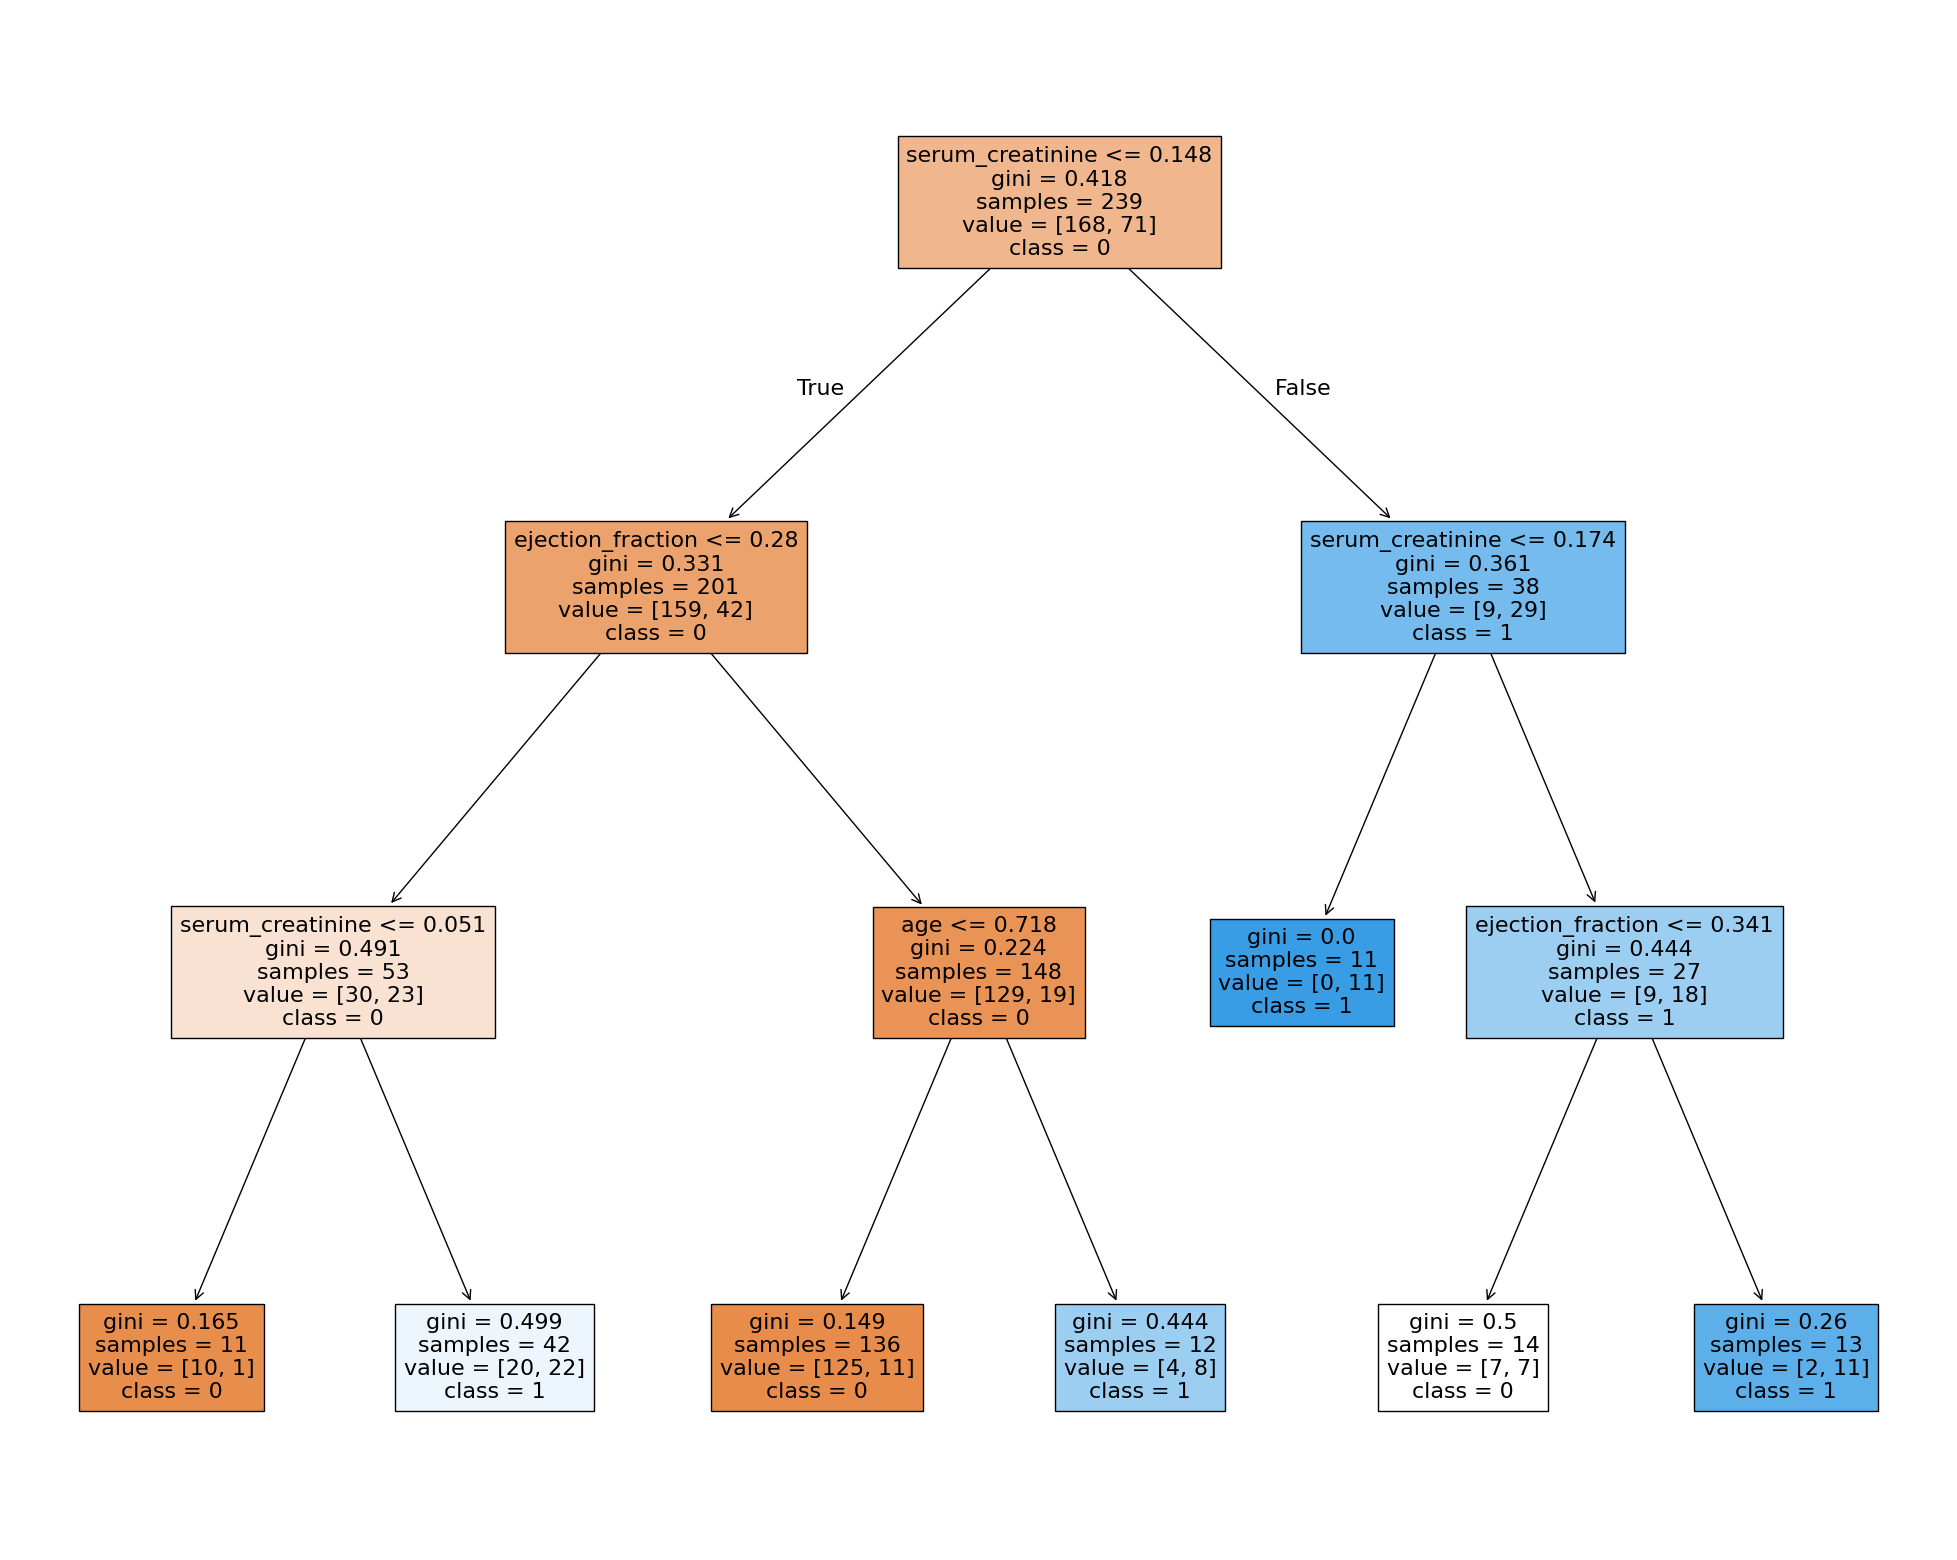

In [142]:
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(dtc, 
                   feature_names=features_name,  
                   class_names=['0','1'],
                   filled=True)